Load the Reuters dataset, a set of short newswires and their topics.

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(nb_words=10000)

Using TensorFlow backend.


Let's take a look at the size of the data.

In [2]:
len(train_data)

8982

In [3]:
len(test_data)

2246

Let's also look at the structure of the data.

In [4]:
train_data[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

Each training example is a list of integers. Each integer is a word index.

Let's also look at the training labels. These should be topics. Each training example is associated with one topic.

In [5]:
train_labels[0]

3

Now we need to turn the training data into tensor input for the neural network. The raw integer list won't work, so we represent each integer list as a matrix, where a 1 denotes the presence of a specific integer.

In [6]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.

    return results

Then we'll store the vectorized training and test data.

In [7]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

The labels consist of integers. Each record has one integer, which is associated with a specific topic. We also need to convert these integers to a tensor (i.e., matrix). One way to do that is to use "categorical encoding", also known as "one-hot" encoding. In this example, we'll make each label an all-zero vector with a 1 in the place of the label index.

In [8]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))

    for i, label in enumerate(labels):
        results[i, label] = 1.

    return results

Then we'll store the vectorized training and test labels.

In [9]:
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

Note that there's also a built-in technique to this in Keras.

In [10]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

Now we're ready to define the network model. We'll try two 64-node hidden layers, with relu activation on the hidden layers and softmax activation on the output layer (topics). The output layer is a 46-dimensional vector where output[i] is the probability that the sample belongs to class i.

In [11]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10000))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

Now we can compile the model. 

In [12]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Now we'll take 1,000 samples from the training data to validate the model.

In [13]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now we're ready to train the network. We'll run 20 epochs on batches on 512.

In [14]:
history = model.fit(partial_x_train, partial_y_train, nb_epoch=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s - loss: 2.6517 - acc: 0.4744 - val_loss: 1.7180 - val_acc: 0.6390
Epoch 2/20
7982/7982 [==============================] - 1s - loss: 1.4278 - acc: 0.7028 - val_loss: 1.2764 - val_acc: 0.7120
Epoch 3/20
7982/7982 [==============================] - 1s - loss: 1.0549 - acc: 0.7761 - val_loss: 1.1031 - val_acc: 0.7650
Epoch 4/20
7982/7982 [==============================] - 1s - loss: 0.8360 - acc: 0.8212 - val_loss: 1.0093 - val_acc: 0.7700
Epoch 5/20
7982/7982 [==============================] - 1s - loss: 0.6691 - acc: 0.8554 - val_loss: 0.9429 - val_acc: 0.8040
Epoch 6/20
7982/7982 [==============================] - 1s - loss: 0.5346 - acc: 0.8901 - val_loss: 0.9163 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s - loss: 0.4340 - acc: 0.9105 - val_loss: 0.8836 - val_acc: 0.8190
Epoch 8/20
7982/7982 [==============================] - 1s - loss: 0.3510 - a

Let's plot the loss values.

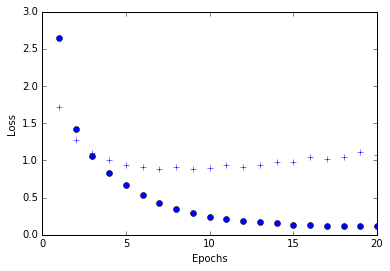

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline  

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo')
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

Let's also plot accuracy values.

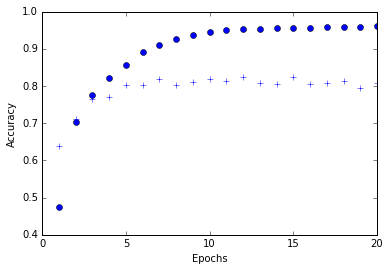

In [16]:
plt.clf()

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

The network starts overfitting around 9 epochs. We can train a new network for 9 epochs and then evaluate its performance on the test data.

In [17]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10000))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, one_hot_train_labels, nb_epoch=9, batch_size=512, validation_data=(x_test, one_hot_test_labels))

results = model.evaluate(x_test, one_hot_test_labels)

Train on 8982 samples, validate on 2246 samples
Epoch 1/9
8982/8982 [==============================] - 1s - loss: 2.4272 - acc: 0.5480 - val_loss: 1.6240 - val_acc: 0.6679
Epoch 2/9
8982/8982 [==============================] - 1s - loss: 1.3094 - acc: 0.7238 - val_loss: 1.3303 - val_acc: 0.7070
Epoch 3/9
8982/8982 [==============================] - 1s - loss: 0.9920 - acc: 0.7826 - val_loss: 1.1538 - val_acc: 0.7556
Epoch 4/9
8982/8982 [==============================] - 1s - loss: 0.7807 - acc: 0.8371 - val_loss: 1.0508 - val_acc: 0.7711
Epoch 5/9
8982/8982 [==============================] - 1s - loss: 0.6176 - acc: 0.8703 - val_loss: 0.9920 - val_acc: 0.7743
Epoch 6/9
8982/8982 [==============================] - 1s - loss: 0.4916 - acc: 0.8981 - val_loss: 0.9580 - val_acc: 0.7907
Epoch 7/9
8982/8982 [==============================] - 1s - loss: 0.3926 - acc: 0.9162 - val_loss: 0.9594 - val_acc: 0.7872
Epoch 8/9
8982/8982 [==============================] - 1s - loss: 0.3222 - acc: 0.93

In [18]:
results

[0.95523836797406814, 0.7907390917186109]

The network reaches about 79% accuracy. We can now confirm that the predict method returns a probability distibution over 46 topics. The highest probability is the predicted topic and the probabilities for all 46 topics should total 1.

In [19]:
predictions = model.predict(x_test)

In [20]:
predictions[0].shape

(46,)

In [21]:
np.sum(predictions[0])

1.0

In [22]:
np.argmax(predictions[0])

3

In [23]:
predictions[0]

array([  7.36875700e-06,   1.31792258e-04,   1.90233586e-05,
         9.56994057e-01,   3.67658585e-02,   4.22762878e-06,
         1.23812979e-05,   5.88455214e-06,   1.46535109e-03,
         2.73685282e-06,   5.38135646e-05,   1.47655519e-04,
         3.21395819e-05,   3.88020235e-05,   1.86623089e-04,
         3.22560809e-05,   1.42498966e-03,   1.32929199e-04,
         3.87849468e-06,   9.76440613e-04,   1.90687599e-04,
         2.51720863e-04,   1.40401544e-05,   2.43639170e-05,
         5.04443460e-06,   1.85524128e-04,   1.62178594e-07,
         8.36334857e-06,   3.04248942e-06,   4.55597401e-05,
         3.68147048e-05,   7.26523649e-05,   5.96785640e-06,
         2.50180778e-06,   1.61474643e-04,   1.16781230e-05,
         7.10493478e-05,   4.63995239e-05,   8.71407246e-06,
         3.87365289e-04,   8.59095564e-07,   1.63560362e-05,
         2.75622506e-06,   7.20789274e-07,   3.08636174e-07,
         7.75121862e-06], dtype=float32)